In [1]:
import scipy.io
import numpy as np
import kaldiio
import tensorflow as tf
import os
import re
from pathlib import Path
import scipy.ndimage.filters
import sklearn.decomposition 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

def writeKaldiData(input_features, transcripts, utt_ids, utt2spk, partition_idx, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    ark_path = os.path.join(output_dir, 'feats.ark')
    scp_path = os.path.join(output_dir, 'feats.scp')
    with kaldiio.WriteHelper(f'ark,scp:{ark_path},{scp_path}') as writer:
        for i in partition_idx:
            writer[utt_ids[i]] = input_features[i]

    with open(os.path.join(output_dir, 'utt2spk'), 'w') as f:
        for i in partition_idx:
            f.write(f'{utt_ids[i]} {utt2spk[i]}\n')

    spk2utt = {spk : [] for spk in utt2spk}
    spk2utt = {}
    for i in partition_idx:
        spk = utt2spk[i]
        if spk not in spk2utt:
            spk2utt[spk] = []
        spk2utt[spk].append(utt_ids[i])

    spks = []
    for spk in spk2utt:
        spks.append(spk)
        spk2utt[spk] = sorted(spk2utt[spk])
    spks = sorted(spks)

    with open(os.path.join(output_dir, 'spk2utt'), 'w') as f:
        for spk in spks:
            f.write(f'{spk} {" ".join(spk2utt[spk])}\n')

    with open(os.path.join(output_dir, 'text'), 'w') as f:
        for i in partition_idx:
            f.write(f'{utt_ids[i]} {transcripts[i].upper()}\n')


def formatSessionGeneral(sessionName, rawDataDir, partitionFolder, outputDataFolder, 
                         partitionSuffix='', featType='sp_and_tx', 
                         includeIFG=False, cutEnd=False, heldOutBlocks=False, 
                         cumulativeMean=False, rollingMean=False, addMeanDriftNoise=False, 
                         useRawRedisData=True, noMeanAdaptation=False, addInterWordSil=True,
                         pca=False, gaussianSmooth=True):
    
    if useRawRedisData:
        lrr_mat = scipy.io.loadmat(rawDataDir+'/'+sessionName+'_20ms_sentences_raw.mat')
    else:
        lrr_mat = scipy.io.loadmat(rawDataDir+'/'+sessionName+'_20ms_sentences_lrr.mat')

    if cutEnd:
        binsToCut = scipy.io.loadmat(rawDataDir+'/'+sessionName+'_binsToRemoveFromEnd.mat')
    else:
        binsToCut = []
        
    input_features = []
    transcriptions = []
    utt_ids = []
    utt2spk = []
    spk2utt = []
    frame_lens = []
    block_means = []
    block_stds = []
    n_trials = lrr_mat['zeroPaddedSentences'].shape[0]

    for i in range(n_trials):    
        features = lrr_mat['zeroPaddedSentences'][i]

        if cutEnd:
            binsToRemove = binsToCut['binsToRemoveFromEnd'][0, i]-40
            if binsToRemove<0:
                binsToRemove = 0
        else:
            binsToRemove = 0

        sentence_len = (lrr_mat['sentenceDurations'][i, 0] - binsToRemove).astype(np.int32)
        if includeIFG:
            features_tx = features[0:sentence_len, 0:256].astype(np.float32)
            features_sp = features[0:sentence_len, 256:512].astype(np.float32)
        else:
            features_tx = features[0:sentence_len, 0:128].astype(np.float32)
            features_sp = features[0:sentence_len, 256:384].astype(np.float32)

        sentence = lrr_mat['sentences'][i][0][0]
        sentence = re.sub(r'[\.,?!,]', '', sentence)

        if featType=='sp_and_tx':
            input_features.append(np.concatenate([features_tx, features_sp], axis=1))
        elif featType=='tx_only':
            input_features.append(features_tx)

        transcriptions.append(sentence)
        frame_lens.append(sentence_len)
        utt_ids.append(sessionName+'_'+str(i))    

    blockList = np.unique(lrr_mat['blockNum'])
    blocks = []
    sentBlocks = lrr_mat['blockNum'][lrr_mat['goTrialEpochs'][:,0]]

    for b in range(len(blockList)):
        sentIdx = np.argwhere(sentBlocks==blockList[b])
        sentIdx = sentIdx[:,0].astype(np.int32)
        blocks.append(sentIdx)
        
    if partitionSuffix=='':
        ttp = scipy.io.loadmat(partitionFolder+'/'+sessionName+'.mat')
    else:
        ttp = scipy.io.loadmat(partitionFolder+'/'+sessionName+'_'+partitionSuffix+'.mat')
    
    if heldOutBlocks:
        #hold out block numbers
        trainPartitionIdx = []
        trainBlocks = np.squeeze(ttp['trainBlocks'])
        for x in range(len(trainBlocks)):
            blockIdx = np.argwhere(trainBlocks[x]==blockList)
            trainPartitionIdx.append(blocks[blockIdx[0,0]])

        testPartitionIdx = []
        testBlocks = np.squeeze(ttp['testBlocks'])
        if testBlocks.shape==():
            testBlocks = [testBlocks]

        for x in range(len(testBlocks)):
            blockIdx = np.argwhere(testBlocks[x]==blockList)
            testPartitionIdx.append(blocks[blockIdx[0,0]])

        trainPartitionIdx = np.concatenate(trainPartitionIdx)
        testPartitionIdx = np.concatenate(testPartitionIdx)

    else:
        #random held out trials
        trainPartitionIdx = np.squeeze(ttp['trainTrials'])
        testPartitionIdx = np.squeeze(ttp['testTrials'])

    print(trainPartitionIdx)
    print(testPartitionIdx)

    if heldOutBlocks and not noMeanAdaptation:
        input_features_raw = input_features.copy()

        if cumulativeMean:
            candidateBlocks = np.concatenate([trainBlocks, testBlocks])
        else:
            candidateBlocks = trainBlocks

        #compute block-specific means and mean-sbutract the training blocks
        allMeans = []
        if_train = []
        for b in range(len(candidateBlocks)):
            blockIdx = np.argwhere(candidateBlocks[b]==blockList)
            blockIdx = blockIdx[0,0]

            feats = np.concatenate(input_features[blocks[blockIdx][0]:(blocks[blockIdx][-1]+1)], axis=0)
            feats_mean = np.mean(feats, axis=0, keepdims=True)
            feats_std = np.std(feats, axis=0, keepdims=True)
            allMeans.append(feats_mean)

            if np.any(candidateBlocks[b]==testBlocks):
                continue

            for i in blocks[blockIdx]:
                input_features[i] = (input_features[i] - feats_mean) #/ (feats_std + 1e-8)
                if_train.append(input_features[i])

        all_std = np.std(np.concatenate(if_train, axis=0), axis=0, keepdims=True) + 1e-8

        #mean-subtract the testing blocks with the closest available prior block
        for b in range(len(testBlocks)):
            blockIdx = np.argwhere(testBlocks[b]==blockList)
            blockIdx = blockIdx[0,0]

            validBlocks = candidateBlocks[candidateBlocks<testBlocks[b]] 
            meanBlockIdx = validBlocks[-1]
            meanBlockIdx = np.argwhere(meanBlockIdx==candidateBlocks)
            meanBlockIdx = meanBlockIdx[0,0]

            sentIdx = 0
            for i in blocks[blockIdx]:
                #rolling mean, take from the last 5 sentences
                nSentMin = 10
                nSentMax = 20
                sentIdx += 1
                if sentIdx>nSentMin and rollingMean:
                    nToTake = min(sentIdx-1, nSentMax)
                    feats = np.concatenate(input_features_raw[(i-nToTake):i], axis=0)
                    feats_mean = np.mean(feats, axis=0, keepdims=True)
                    meanToSubtract = feats_mean
                else:
                    meanToSubtract = allMeans[meanBlockIdx]

                input_features[i] = (input_features[i] - meanToSubtract)

        for i in range(len(input_features)):
            input_features[i] = input_features[i] / all_std

        if addMeanDriftNoise:
            for b in range(len(testBlocks)):
                blockIdx = np.argwhere(testBlocks[b]==blockList)
                blockIdx = blockIdx[0,0]

                for i in blocks[blockIdx]:
                    meanDirftNoise = np.random.randn(1,input_features[0].shape[1])*0.6
                    input_features[i] = (input_features[i] + meanDirftNoise)        

    elif not noMeanAdaptation:
        for b in range(len(blocks)):
            feats = np.concatenate(input_features[blocks[b][0]:(blocks[b][-1]+1)], axis=0)
            feats_mean = np.mean(feats, axis=0, keepdims=True)
            feats_std = np.std(feats, axis=0, keepdims=True)
            for i in blocks[b]:
                input_features[i] = (input_features[i] - feats_mean) #/ (feats_std + 1e-8)
                utt2spk.append(sessionName + '_' + str(b))

        all_std = np.std(np.concatenate(input_features, axis=0), axis=0, keepdims=True) + 1e-8
        for i in range(len(input_features)):
            input_features[i] = input_features[i] / all_std

    if gaussianSmooth:
        input_features = [scipy.ndimage.filters.gaussian_filter1d(feat, 2.0, axis=0) for feat in input_features]
    if pca:
        feats_all = np.concatenate(input_features, axis=0)
        pcaModel = sklearn.decomposition.PCA(n_components=13)
        pcaModel.fit(feats_all)
        input_features = [pcaModel.transform(feat) for feat in input_features]

    
    feats_all = np.concatenate(input_features, axis=0)
    plt.figure(figsize=(10, 4))
    plt.imshow(feats_all.T, aspect='auto',
               interpolation='none', clim=[0,2])
    plt.xlim([20000,25000])
    plt.ylabel('neurons')
    plt.xlabel('time [20ms]')
    plt.tight_layout()


    writeKaldiData(input_features, transcriptions, utt_ids, utt2spk, trainPartitionIdx, 
                   os.path.join(outputDataFolder, sessionName, 'train'))
    writeKaldiData(input_features, transcriptions, utt_ids, utt2spk, testPartitionIdx, 
                   os.path.join(outputDataFolder, sessionName, 'test'))

    


/oak/stanford/groups/shenoy/ekunz/SpeechHMM/SimDataset2/RedisMat/20211208_105013_(14).mat
/oak/stanford/groups/shenoy/ekunz/SpeechHMM/SimDataset2/TaskData/SpeechTask/speechOpenLoop_data_20211208_101212_(14).mat
/oak/stanford/groups/shenoy/ekunz/SpeechHMM/SimDataset2/RedisMat/20211208_105630_(15).mat
/oak/stanford/groups/shenoy/ekunz/SpeechHMM/SimDataset2/TaskData/SpeechTask/speechOpenLoop_data_20211208_101220_(15).mat
/oak/stanford/groups/shenoy/ekunz/SpeechHMM/SimDataset2/RedisMat/20211208_110601_(17).mat
/oak/stanford/groups/shenoy/ekunz/SpeechHMM/SimDataset2/TaskData/SpeechTask/speechOpenLoop_data_20211208_111250_(17).mat
/oak/stanford/groups/shenoy/ekunz/SpeechHMM/SimDataset2/RedisMat/20211208_111821_(18).mat
/oak/stanford/groups/shenoy/ekunz/SpeechHMM/SimDataset2/TaskData/SpeechTask/speechOpenLoop_data_20211208_111223_(18).mat
/oak/stanford/groups/shenoy/ekunz/SpeechHMM/SimDataset2/RedisMat/20211208_112417_(19).mat
/oak/stanford/groups/shenoy/ekunz/SpeechHMM/SimDataset2/TaskData/S

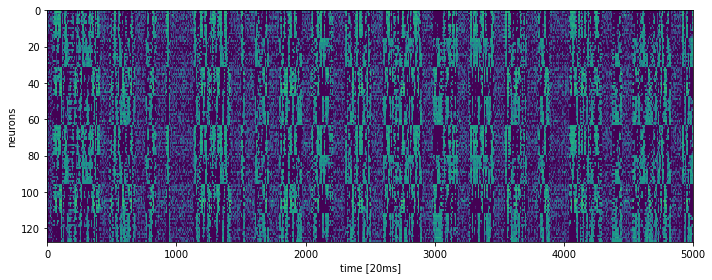

In [79]:
from neuralDecoder.utils.handwritingDataUtils import *


blocks = [14, 15, 17, 18, 19, 20, 21, 22, 23, 24]
session = 't12_simulated'
rootDir = f'/oak/stanford/groups/shenoy/ekunz/SpeechHMM/SimDataset2'

sessionData = formatSessionData(blocks, {}, rootDir, channels=512, 
                                task='SpeechTask', 
                                includeSpikePower=False, globalStd=True)

sessionData['inputFeatures'] = [np.concatenate((f[:, :128], f[:, 256:384]), -1) for f in sessionData['inputFeatures']]
sessionData['blockMeans'] = [np.concatenate((f[:, :128], f[:, 256:384]), -1) for f in sessionData['blockMeans']]
sessionData['blockStds'] = [np.concatenate((f[:, :128], f[:, 256:384]), -1) for f in sessionData['blockStds']]
sessionData['transcriptions'] = [t.upper() for t in sessionData['transcriptions']]

utt_ids = [f'utt_{i}' for i in range(len(sessionData['inputFeatures']))]
utt2spk = [f'spk_{i // 20}' for i in range(len(sessionData['inputFeatures']))]

plt.figure(figsize=(10, 4))
plt.imshow(np.concatenate(sessionData['inputFeatures'], 0).T, aspect='auto',
           interpolation='none', clim=[0,2])
plt.xlim([0,5000])
plt.ylabel('neurons')
plt.xlabel('time [20ms]')
plt.tight_layout()

writeKaldiData(sessionData['inputFeatures'], 
               sessionData['transcriptions'], 
               utt_ids, 
               utt2spk, 
               np.arange(0, 180), 
               os.path.join('/oak/stanford/groups/shenoy/stfan/code/kaldi/egs/brain2text/s5/kaldi_data', 't12_simulated', 'train'))

writeKaldiData(sessionData['inputFeatures'], 
               sessionData['transcriptions'], 
               utt_ids, 
               utt2spk, 
               np.arange(180, 200), 
               os.path.join('/oak/stanford/groups/shenoy/stfan/code/kaldi/egs/brain2text/s5/kaldi_data', 't12_simulated', 'test'))

In [75]:
len(sessionData['inputFeatures'])

200

[327 391 155 437 386 249  97   4 300 166 381 244  18 254 307 106   2 346
 412 146 109 269  32  99  88 343 180 105  90 320 159 262 139 172  95  47
 305 373 345 387 334 410  15 400 236  60  55  57  17 359 428 246 165 171
 124  89 189 390 188 207  80 394 280 323 438 162 319 237 432 149  23 342
 415  31  39  72  34 167 132 138 309 195  42 358 193 368  13 279  36  71
 335  69 127 122 317 257  21 160  74 364 181  81 377 389 374 232  50 185
 336 103 419  44 150  68 298  98  76 220  53 356 369 267 110 399 174  25
 228 365  62 242  54 175 340 407  20 200   9 276 216 311 211 337 286 282
 101 434  96 362 353 268 301 352 194 294 229 116 321 288  30 420 223  37
  70  38 333 123 256 252 143 325 326 351 231  51 255 192 292  83 295 273
 145 392 156 259 179 270 152 218  78 140 313 178 277  92 401 408 217 197
 383 283 104 436 402 414 199 100 376 315 397 396 133 233 372 370 134 287
  94 131 151 271   5 329 264  26 258  91 115 235  75 304 196 289 405 118
  77 404 206  73   8 222  45 212   6  27   3 293 43

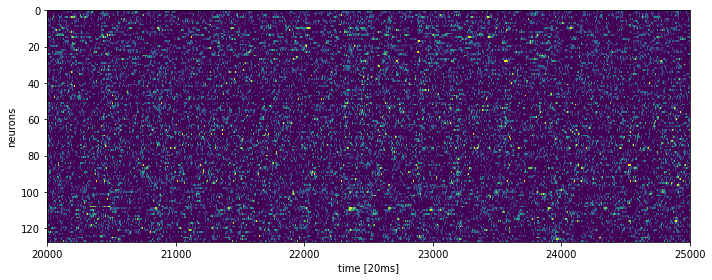

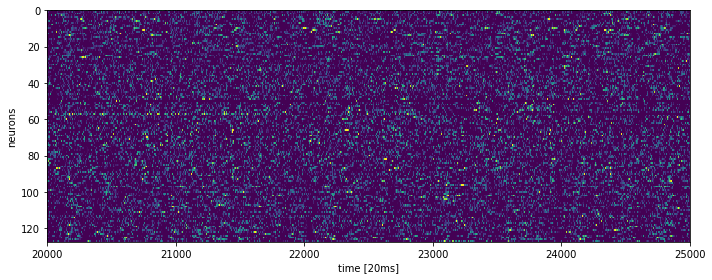

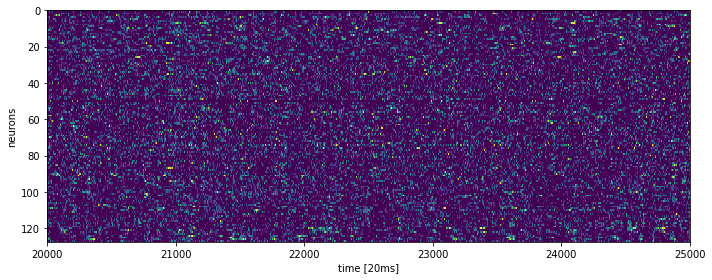

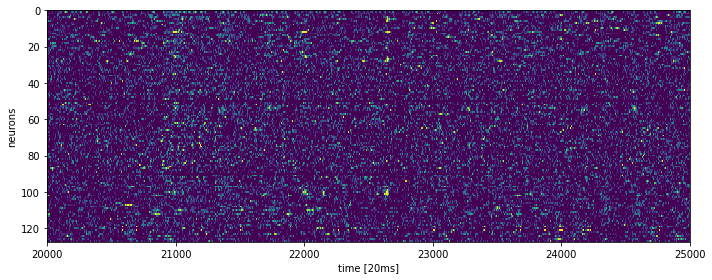

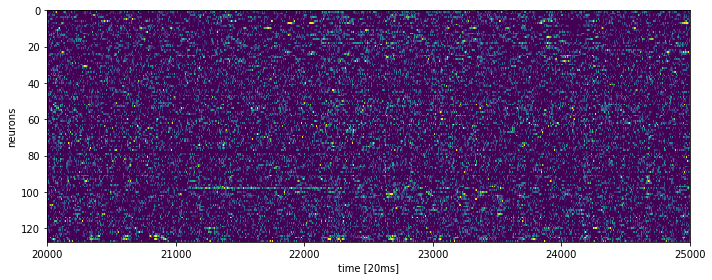

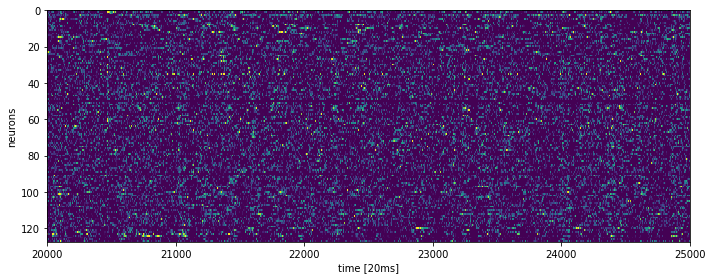

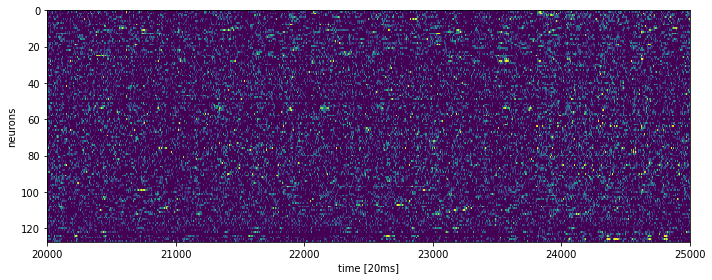

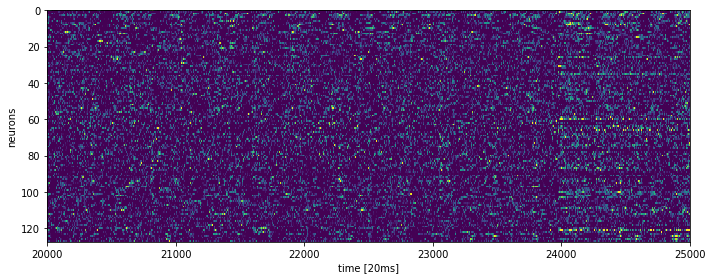

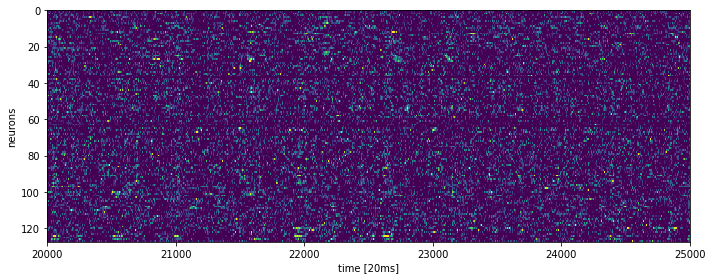

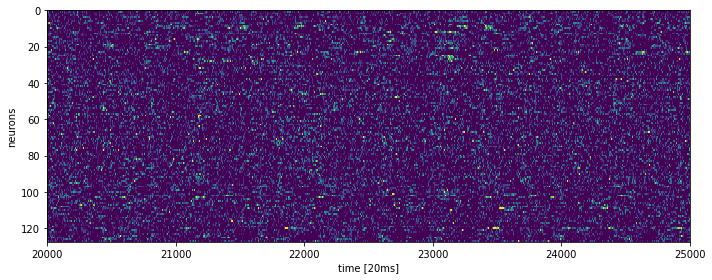

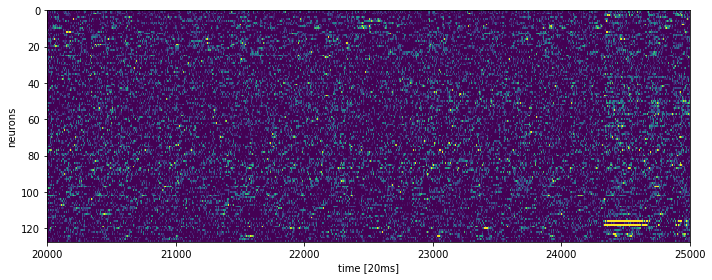

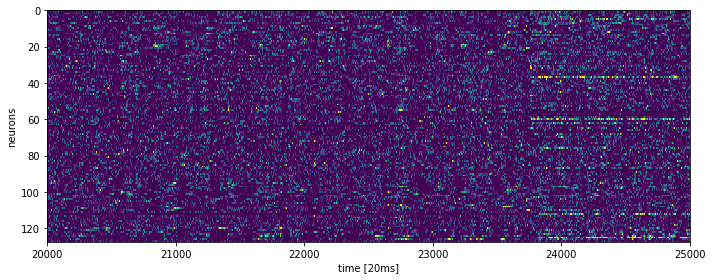

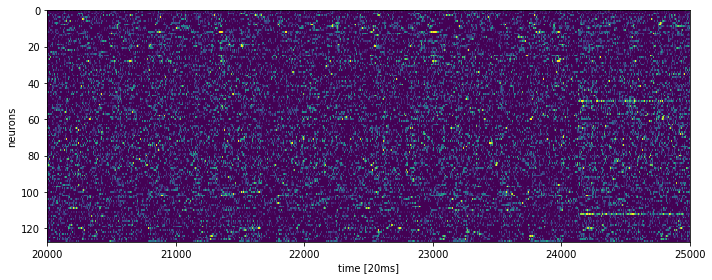

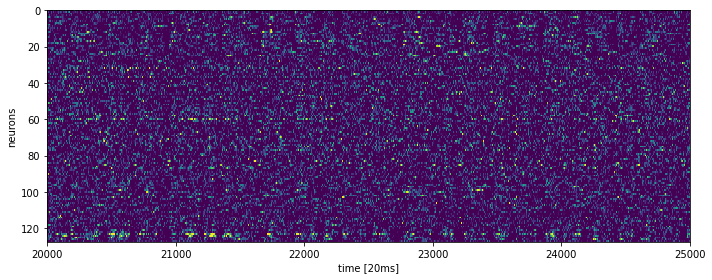

In [2]:
sessions = [
    't12.2022.06.14',
    't12.2022.06.16',
    't12.2022.06.21',
    't12.2022.06.28',
    't12.2022.07.05',
    't12.2022.07.14',
    't12.2022.07.21',
    't12.2022.07.27',
    't12.2022.08.02',
    't12.2022.08.11',
    't12.2022.08.13',
    't12.2022.08.16',
    't12.2022.08.18',
    't12.2022.08.23',
]

for session in sessions:
    formatSessionGeneral(sessionName=session,
                         rawDataDir='/home/groups/shenoy/fwillett/speech/rawData/',
                         partitionFolder='/home/groups/shenoy/fwillett/speech/trainTestPartitions/',
                         outputDataFolder='/oak/stanford/groups/shenoy/stfan/code/kaldi/egs/brain2text/s5/kaldi_data',
                         featType='tx_only',
                         pca=False)

In [82]:
%%bash

export LC_ALL=C

data_dir=/oak/stanford/groups/shenoy/stfan/code/kaldi/egs/brain2text/s5/kaldi_data/
for f in `ls $data_dir`; do
    echo $f
    train_dir=$data_dir/$f/train
    sort $train_dir/feats.scp > $train_dir/feats.scp.sorted
    mv $train_dir/feats.scp.sorted $train_dir/feats.scp
    sort $train_dir/text > $train_dir/text.sorted
    mv $train_dir/text.sorted $train_dir/text


    test_dir=$data_dir/$f/test
    sort $test_dir/feats.scp > $test_dir/feats.scp.sorted
    mv $test_dir/feats.scp.sorted $test_dir/feats.scp
    sort $test_dir/text > $test_dir/text.sorted
    mv $test_dir/text.sorted $test_dir/text
done


t12.2022.06.14
t12.2022.06.16
t12.2022.06.21
t12.2022.06.28
t12.2022.07.05
t12.2022.07.14
t12.2022.07.21
t12.2022.07.27
t12.2022.08.02
t12.2022.08.11
t12.2022.08.13
t12.2022.08.16
t12.2022.08.18
t12.2022.08.23
t12_simulated


In [3]:
%%bash
export LC_ALL=C

data_dir=/oak/stanford/groups/shenoy/stfan/code/kaldi/egs/brain2text/s5/kaldi_data/
train_data=/oak/stanford/groups/shenoy/stfan/code/kaldi/egs/brain2text/s5/data/train/
test_data=/oak/stanford/groups/shenoy/stfan/code/kaldi/egs/brain2text/s5/data/test/

mkdir -p $train_data $test_data

for f in feats.scp spk2utt text utt2spk; do
    for s in `ls $data_dir`; do
      cat $data_dir/$s/train/$f || exit 1;
    done > $train_data/$f || exit 1
    
    sort $train_data/$f > $train_data/$f.sorted
    mv $train_data/$f.sorted $train_data/$f

done

for f in feats.scp spk2utt text utt2spk; do
    for s in `ls $data_dir`; do
      cat $data_dir/$s/test/$f || exit 1;
    done > $test_data/$f || exit 1
    
    sort $test_data/$f > $test_data/$f.sorted
    mv $test_data/$f.sorted $test_data/$f

done

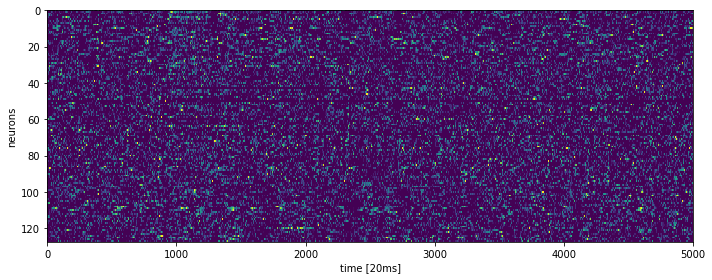

In [5]:
os.chdir('/oak/stanford/groups/shenoy/stfan/code/kaldi/egs/brain2text/s5')
feats = []
with kaldiio.ReadHelper('scp:/oak/stanford/groups/shenoy/stfan/code/kaldi/egs/brain2text/s5/data/test/feats.scp') as reader:
    for key, feat in reader:
        #print(feat.shape)
        #print(feat)
        #break
        feats.append(feat)

feats = np.concatenate(feats, axis=0)
#print(feats.shape)
#print(np.mean(feats, axis=0))
#print(np.std(feats, axis=0))

plt.figure(figsize=(10, 4))
plt.imshow(feats.T, aspect='auto',
           interpolation='none', clim=[0,2])
plt.xlim([0,5000])
plt.ylabel('neurons')
plt.xlabel('time [20ms]')
plt.tight_layout()

In [3]:
!pwd

/oak/stanford/groups/shenoy/stfan/code/nptlrig2/NeuralDecoder
